# Twitter Sentiment Analysis Stock Price Prediction

### - Crawl data

### - Sentiment Analysis

### - Predict Stock

## Import module

In [1]:
from textblob import TextBlob
import math
from collections import Counter, defaultdict
import tweepy as tw
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
%matplotlib inline
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

## Set up token API

In [2]:
api_key = "HAcIeikl6eRheQP1oKYGDwPx0"
api_secret = "gEWmqG7QVXzudnviUXDo98L2UKGYg9PNqy1bAR1geClkHjqBGk"
access_token = "1481095074465579008-1pApYlU4HRJWpbAXcbdVEVGzdACuEz"
access_token_secret = "htgD81H4mOxXw5MglAljFRHhcfGAuwsNomXVqvGw0Obwe"
auth = tw.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth,wait_on_rate_limit=True)

## Crawl data

In [3]:
def apiSearch(kw, number_of_tweets, tweets, user_id, created_at):
    for i in tw.Cursor(api.search, q = kw , lang ="en", since = "2022-01-14",tweet_mode = "extended").items(number_of_tweets):
        tweets.append(i.full_text)
        user_id.append(i.user.id)
        created_at.append(i.created_at)

In [4]:
number_of_tweets = 100
tweets = []
user_id =[]
created_at = []
keyword_list = ['News', 'Stock', 'Customers', 'Employees', 'Company', 'Price', 
                'Shareholders', 'Market', 'Soaring', 'Trends']
company = 'Amazon'
final_kw_list = []

# Crawl data from keywords
for i in range (len(keyword_list)):
    kw = str(company + ' ' + keyword_list[i])
    print(kw)
    final_kw_list.append(kw)
    for i in tw.Cursor(api.search, q = kw , lang ="en", since = "2022-01-14",tweet_mode = "extended").items(number_of_tweets):
        tweets.append(i.full_text)
        user_id.append(i.user.id)
        created_at.append(i.created_at)



Amazon News
Amazon Stock
Amazon Customers
Amazon Employees
Amazon Company
Amazon Price
Amazon Shareholders
Amazon Market
Amazon Soaring
Amazon Trends


## Dataframe

In [5]:
df = pd.DataFrame({"Created_at": created_at,"User_id": user_id,"Tweets":tweets})
df

,Created_at,User_id,Tweets
0,2022-02-04 15:10:02,46797861,RT @LOTRUpdates: Welcome to Lord the Rings Upd...
1,2022-02-04 15:10:01,25636822,"Warming Trends: Elon Musk Haggles Over Hunger,..."
2,2022-02-04 15:09:54,1285381689750032384,Let it burn. https://t.co/bSGta9wgnP
3,2022-02-04 15:09:44,113369057,"RT @carlboutet: $150,000,000,000.00 in 12 minu..."
4,2022-02-04 15:09:35,941817388470800384,RT @LakeCtryPress: Did you hear the news #reyl...
...,...,...,...
995,2022-02-02 23:17:40,235133788,"RT @SN_news: Amazon Fresh, Whole Foods traffic..."
996,2022-02-02 23:06:14,154313392,"Check out this link by Digital Trends, which m..."
997,2022-02-02 22:45:34,1200330399102197761,Announcing the launch of the model copy featur...
998,2022-02-02 22:15:43,1241868210410065920,Is Amazon the new TikTok dance trends


## Clean data

In [6]:
df = df[~df.Tweets.str.contains("RT")]
df = df.reset_index(drop = True)

In [7]:
def cleanUpTweet(text):
    text = re.sub(r'@[A-Za-z0-9_]+','',text) # Remove mentions @
    text = re.sub(r'#', '', text) # Remove hastag symbol
    text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', text) # Remove hyper link
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # Remove special characters
    #Remove stop words
    res = ''
    for word in text.split():
        if word not in stopwords.words('english'):
            res += WordNetLemmatizer().lemmatize(word) + ' '
            
    return res

In [8]:
df['Tweets'] = df['Tweets'].apply(cleanUpTweet)
df = df.drop_duplicates(subset='Tweets')
df = df.reset_index(drop=True)
df

,Created_at,User_id,Tweets
0,2022-02-04 15:10:01,25636822,Warming Trends Elon Musk Haggles Over Hunger H...
1,2022-02-04 15:09:54,1285381689750032384,Let burn
2,2022-02-04 15:09:28,351229472,AMZN I got email Tipranks news Feb 04 2022 Ama...
3,2022-02-04 15:09:28,1372627848385728518,Amazon burn worker quickly executive worried r...
4,2022-02-04 15:09:06,17526930,Amazon Spent 13 Billion Film TV Music Content ...
...,...,...,...
407,2022-02-03 01:02:07,1484338868438515713,It interesting Amazon try connect people refer...
408,2022-02-03 01:00:01,1209806690167803904,Amazon reveals voice cast The Boys Diabolical ...
409,2022-02-02 23:06:14,154313392,Check link Digital Trends movie watch get moti...
410,2022-02-02 22:45:34,1200330399102197761,Announcing launch model copy feature Amazon Co...


## Create clean data list

In [9]:
cleaned_data=[]
for tw in df['Tweets']:
    cleaned_data.append(tw)
    
cleaned_data

['Warming Trends Elon Musk Haggles Over Hunger How Warming Makes Birds Smaller Wings Longer Better Glitter From Nanoparticles ',
 'Let burn ',
 'AMZN I got email Tipranks news Feb 04 2022 Amazon AMZN stock price going 5 00 10 03 ',
 'Amazon burn worker quickly executive worried run people employ ',
 'Amazon Spent 13 Billion Film TV Music Content 2021 18 via ',
 'QQQ good job number Amazon outperformed All good news gotta bullish today today ',
 'Wall Street mixed investor weigh surprising job report Amazon earnings ',
 'Bitcoin Ether gain strong earnings Amazon bolstered confidence technology stock digital token largely tracked past month ',
 'Amazon set huge gain Meta record one day loss happening market NASDAQ AMZN set could biggest one day gain stock market history ',
 'According data released Wednesday deforestation Brazilian Amazon set new record January three week year worrying sign surging destruction world biggest rainforest ',
 'Amazon Prime Raises Subscription Prices ',
 'Ama

## WordCloud Visualization

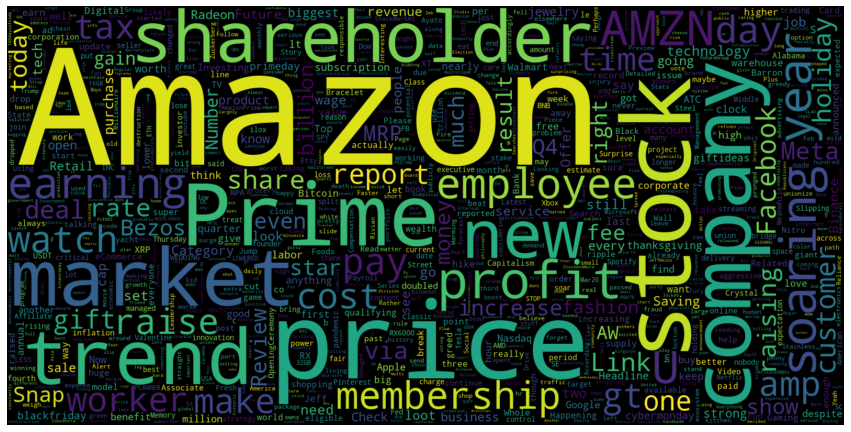

In [10]:
# Plot the word cloud 
allWords = ' '.join( [twts for twts in df['Tweets']] )
positiveWordCloud = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(allWords)
plt.figure(figsize = (15,15))
plt.imshow(positiveWordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()


## Sentiment Analysis

In [11]:
# Create function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create function to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Function compute negative, positive
def getAnalysis(score):
    if score < 0: 
        return np.int_(0)
    elif score > 0:
        return np.int_(1)
    else:
        return 'Neutral'
    
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)
df['Sentiment'] = df['Polarity'].apply(getAnalysis)
df.drop(df.loc[df['Sentiment']=='Neutral'].index, inplace=True)
df = df.reset_index(drop=True)
df

,Created_at,User_id,Tweets,Subjectivity,Polarity,Sentiment
0,2022-02-04 15:10:01,25636822,Warming Trends Elon Musk Haggles Over Hunger H...,0.500000,0.250000,1
1,2022-02-04 15:09:28,1372627848385728518,Amazon burn worker quickly executive worried r...,0.500000,0.333333,1
2,2022-02-04 15:09:06,17526930,Amazon Spent 13 Billion Film TV Music Content ...,0.100000,-0.100000,0
3,2022-02-04 15:09:05,1263808881714704387,QQQ good job number Amazon outperformed All go...,0.600000,0.700000,1
4,2022-02-04 15:09:02,44698675,Wall Street mixed investor weigh surprising jo...,0.375000,0.350000,1
...,...,...,...,...,...,...
251,2022-02-03 01:55:12,22896082,program buzz finger amp wake amp fit bit keep ...,0.450000,0.200000,1
252,2022-02-03 01:30:49,1162775438281891840,Fashion Watch Wholesale Geneva Super Large Str...,0.549048,0.182857,1
253,2022-02-03 01:02:07,1484338868438515713,It interesting Amazon try connect people refer...,0.445714,0.342857,1
254,2022-02-02 22:45:34,1200330399102197761,Announcing launch model copy feature Amazon Co...,0.416667,-0.083333,0


In [12]:
# Save as CSV file
df.to_csv('Amazon.csv')

In [13]:
# Display 5 positive tweets
j = 0
sortedDF = df.sort_values(by=['Polarity'])
positiveTweets = ''
for i in range(sortedDF.shape[0]):
    if sortedDF['Sentiment'][i] == 1:
        print(str(j) + ') ' + sortedDF['Tweets'][i])
        positiveTweets += (' ' + sortedDF['Tweets'][i])
        print()
        j+=1
    if j == 5:
        break



0) Warming Trends Elon Musk Haggles Over Hunger How Warming Makes Birds Smaller Wings Longer Better Glitter From Nanoparticles 

1) Amazon burn worker quickly executive worried run people employ 

2) QQQ good job number Amazon outperformed All good news gotta bullish today today 

3) Wall Street mixed investor weigh surprising job report Amazon earnings 

4) Bitcoin Ether gain strong earnings Amazon bolstered confidence technology stock digital token largely tracked past month 



In [14]:
# Display 5 negative tweets
j = 0
sortedDF = df.sort_values(by=['Polarity'])
negativeTweets = ''
for i in range(sortedDF.shape[0]):
    if sortedDF['Sentiment'][i] == 0:
        print(str(j) + ') ' + sortedDF['Tweets'][i] )
        negativeTweets += (' ' + sortedDF['Tweets'][i])
        print()
        j+=1
    if j == 5:
        break

0) Amazon Spent 13 Billion Film TV Music Content 2021 18 via 

1) 150 000 000 000 00 12 minute world living Just perspective half Costco current market cap third Walmart But hey innovation Amazon 

2) Amazon unlimited free shipping Prime member get little expensive 

3) Amazon May Have Saved Stock Market But It Looking Even Worse Meta via 

4) Worst customer care experience amazon unable resolve issue since three month also charge adding day day stock stuck fc also contacted 100 time much harrasment 



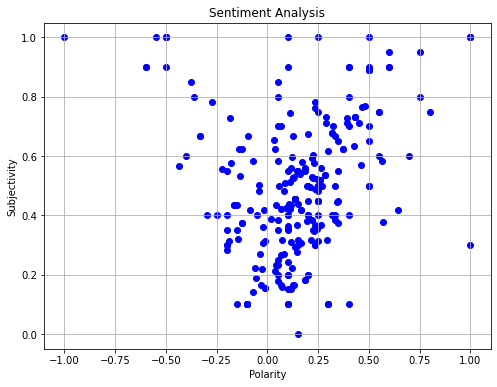

In [15]:
# Plot popularity and subjectivity
plt.figure(figsize=(8,6))
for i in range(df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color='Blue')
    
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.grid(True)
plt.show()

## Train model

In [19]:
class Tokenizer:
  
  def clean(self, text):
      no_html = BeautifulSoup(text).get_text()
      clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
      return re.sub("(\s+)", " ", clean)

 
  def tokenize(self, text):
      clean = self.clean(text).lower()
      stopwords_en = stopwords.words("english")
      return [w for w in re.split("\W+", clean) if not w in stopwords_en]

In [16]:
class MultinomialNaiveBayes:
  
    def __init__(self, classes, tokenizer):
      self.tokenizer = tokenizer
      self.classes = classes
      
    def group_by_class(self, X, y):
      data = dict()
      for c in self.classes:
        data[c] = X[np.where(y == c)]
      return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in data:
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
      
    def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      
    def predict(self, X):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result

In [37]:
X = df['Tweets'].values
y = df['Sentiment'].values.astype('float')
RANDOM_SEED = 1
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


In [38]:
MNB = MultinomialNaiveBayes(
    classes=np.unique(y), 
    tokenizer=Tokenizer()
).fit(X_train, y_train)


In [39]:
y_pred = np.array(MNB.predict(X_test))
print(y_test)
print(y_pred)

[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1.
 0. 1. 1. 0.]
[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]


In [40]:
accuracy_score(y_test, y_pred)

0.75

In [41]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.07      0.13        14
         1.0       0.75      1.00      0.85        38

    accuracy                           0.75        52
   macro avg       0.87      0.54      0.49        52
weighted avg       0.81      0.75      0.66        52



In [42]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 1, 13],
       [ 0, 38]], dtype=int64)

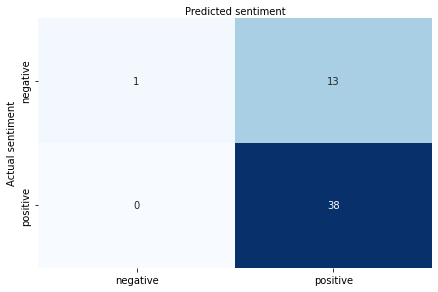

In [43]:
class_names = ["negative", "positive"]
fig,ax = plt.subplots()


sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');